# Proyek Akhir: Menyelesaikan Permasalahan Jaya Jaya Institut
- Nama: Rio Ferdinand
- Email: riof414@gmail.com
- Id Dicoding: A180YBM432

## Persiapan

### Menyiapkan library yang dibutuhkan

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


### Menyiapkan data yang akan digunakan

Memuat dataset `data.csv` yang berisi informasi siswa Jaya Jaya Institut

In [2]:
# Ganti path jika perlu
df = pd.read_csv('data.csv', sep=';')
print(f"Dimensi data: {df.shape}")
df.head()

Dimensi data: (4424, 37)


,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## Data Understanding

Tahap ini dilakukan untuk mengetahui tipe data tiap kolom, jumlah data, informasi nilai null dan nilai duplikat serta distribusi Status siswa

In [3]:
# Tipe kolom & non-null count
df.info()

# Total missing per kolom
print("\nMissing value :")
print(df.isnull().sum())

print("\nDuplicated value :")
print(df.duplicated().sum())

df['Status'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Marital_status                                4424 non-null   int64  
 1   Application_mode                              4424 non-null   int64  
 2   Application_order                             4424 non-null   int64  
 3   Course                                        4424 non-null   int64  
 4   Daytime_evening_attendance                    4424 non-null   int64  
 5   Previous_qualification                        4424 non-null   int64  
 6   Previous_qualification_grade                  4424 non-null   float64
 7   Nacionality                                   4424 non-null   int64  
 8   Mothers_qualification                         4424 non-null   int64  
 9   Fathers_qualification                         4424 non-null   i

Status
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

## Data Preparation / Preprocessing

- Tahap ini bertujuan untuk membersihkan dan menyiapkan data untuk klasifikasi biner dengan memilih fitur penting dan mengubah label target 'Graduate' dan 'Dropout' menjadi numerik 0 dan 1. 
- Data numerik yang berformat string dibersihkan dari pemisah ribuan dan desimal agar bisa diproses, lalu baris yang mengandung nilai kosong dihapus. 
- Fitur kategorikal di-encode menjadi angka menggunakan LabelEncoder agar kompatibel dengan model. 
- Terakhir, data dibagi menjadi set pelatihan dan pengujian dengan stratifikasi agar proporsi kelas tetap seimbang, dan random state ditetapkan untuk hasil yang konsisten.

In [ ]:
    selected_features = [
        'Admission_grade',
        'Age_at_enrollment',
        'Curricular_units_1st_sem_grade',
        'Curricular_units_2nd_sem_grade',
        'Previous_qualification_grade',
        'Debtor',
        'Tuition_fees_up_to_date',
        'Scholarship_holder',
        'Daytime_evening_attendance',
        'Gender',
        'Displaced',
        'Educational_special_needs'
    ]

    # Salin data
    df_clean = df.copy()

    # Mapping label, buat hanya yang Graduate dan Dropout
    label_map = {'Graduate': 0, 'Dropout': 1}
    df_clean['Status'] = df_clean['Status'].map(label_map)

    # Hapus baris yang Status NaN (karena bukan Graduate/Dropout)
    df_clean = df_clean.dropna(subset=['Status']).copy()

    # Fungsi pembersih angka string
    def clean_numeric_string(value):
        if isinstance(value, str):
            # Jika data pakai koma sebagai desimal dan titik sebagai ribuan, ubah begini:
            # Contoh: "1.234,56" -> "1234.56"
            value = value.replace('.', '').replace(',', '.')
            try:
                return float(value)
            except:
                return np.nan
        return value

    # Bersihkan data di fitur numerik saja (yang dipilih)
    for col in selected_features:
        df_clean[col] = df_clean[col].apply(clean_numeric_string)

    # Hapus baris yang masih ada null di fitur yang dipakai
    df_clean.dropna(subset=selected_features, inplace=True)

    # Ekstraksi X dan y
    X = df_clean[selected_features].copy()
    y = df_clean['Status'].astype(int).copy()

    # Encode fitur kategorikal (yang bertipe object)
    label_encoders = {}
    categorical_cols = X.select_dtypes(include='object').columns

    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le


    # Split data dengan stratify
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

## EDA

Tahap ini bertujuan untuk eksplorasi data dengan visualisasi dan statistik untuk melihat distribusi target 'Status' serta hubungan fitur numerik dan kategorikal penting dengan status mahasiswa, termasuk usia, nilai masuk, status finansial, dan nilai semester. Tujuannya untuk memahami pola perbedaan antara mahasiswa yang lulus dan yang dropout.

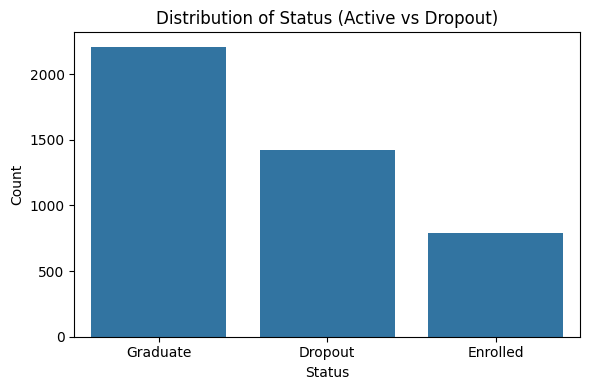

<Figure size 640x480 with 0 Axes>

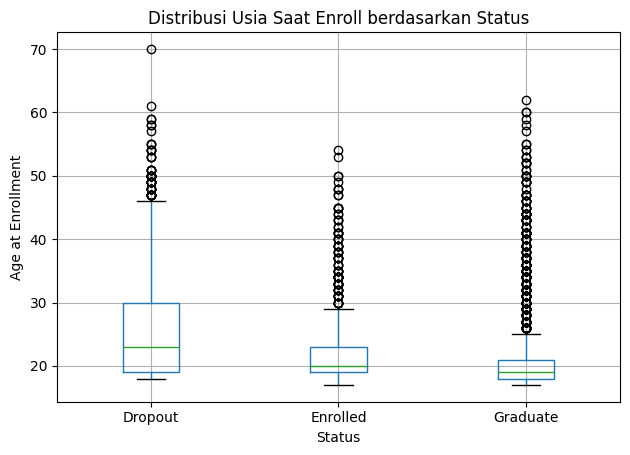

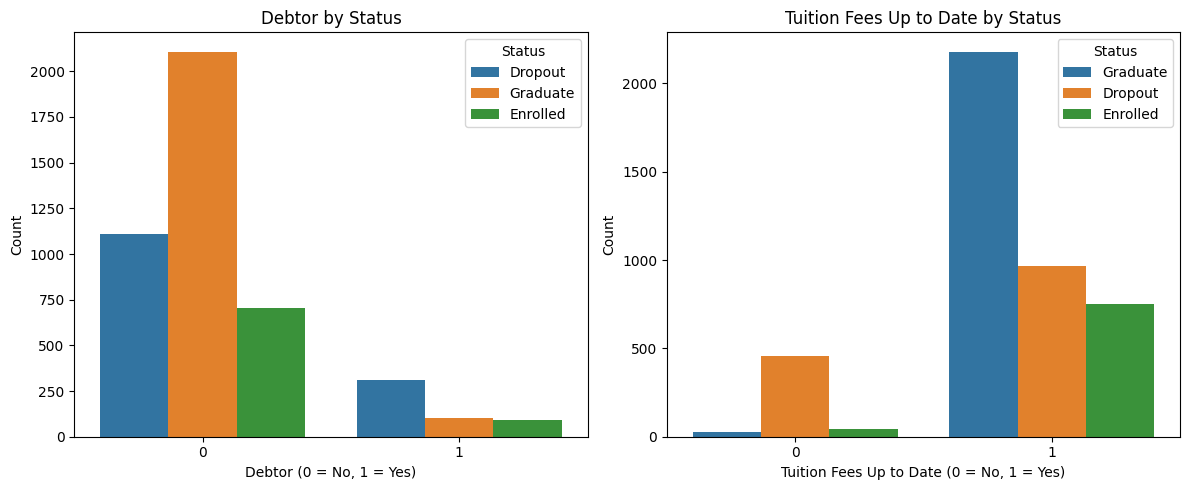

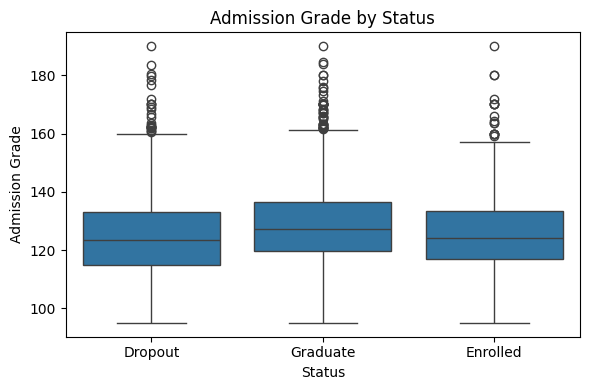

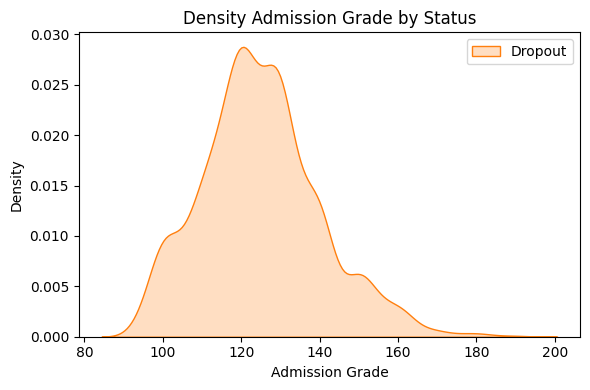

Descriptive Statistics Admission_grade per Status:
            count    mean    std   min    25%    50%     75%    max
Status                                                            
Dropout   1421.0  124.96  15.13  95.0  115.0  123.6  133.00  190.0
Enrolled   794.0  125.53  13.79  95.0  117.0  124.1  133.28  190.0
Graduate  2209.0  128.79  14.07  95.0  119.7  127.4  136.40  190.0


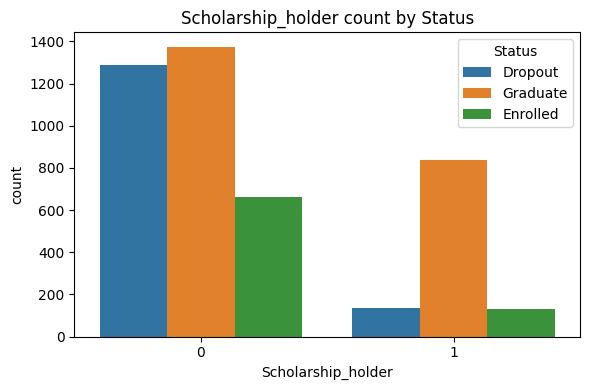

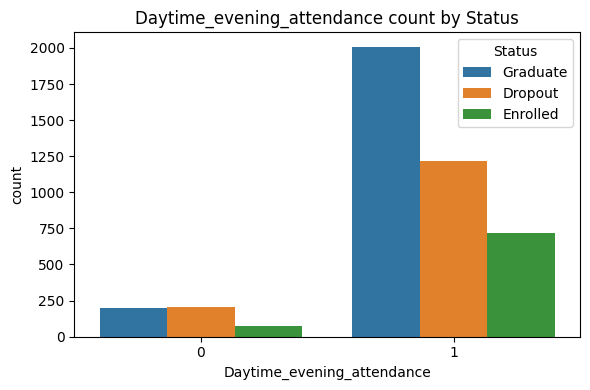

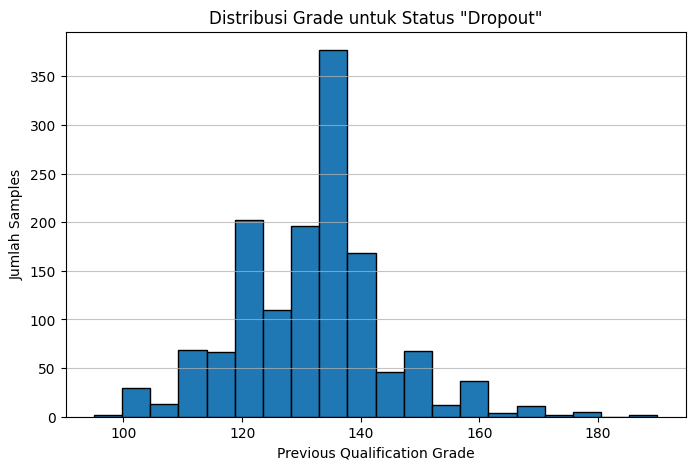

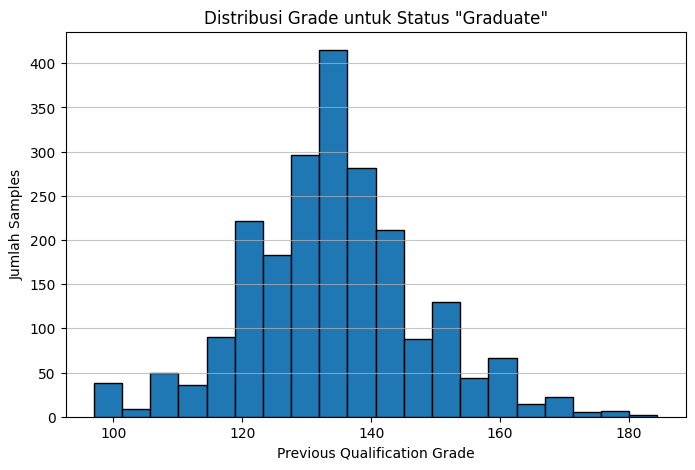

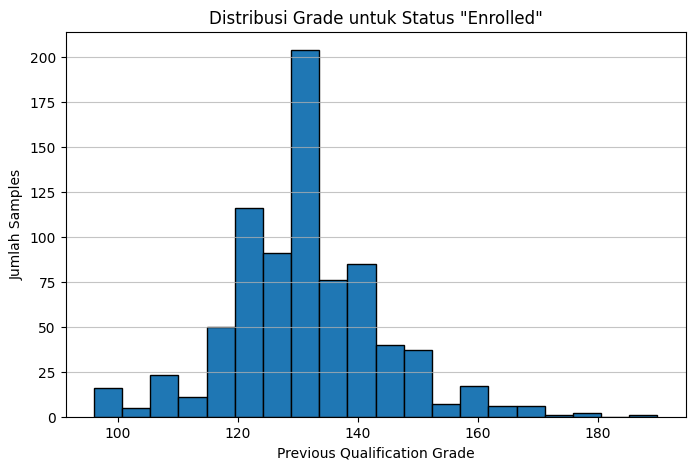

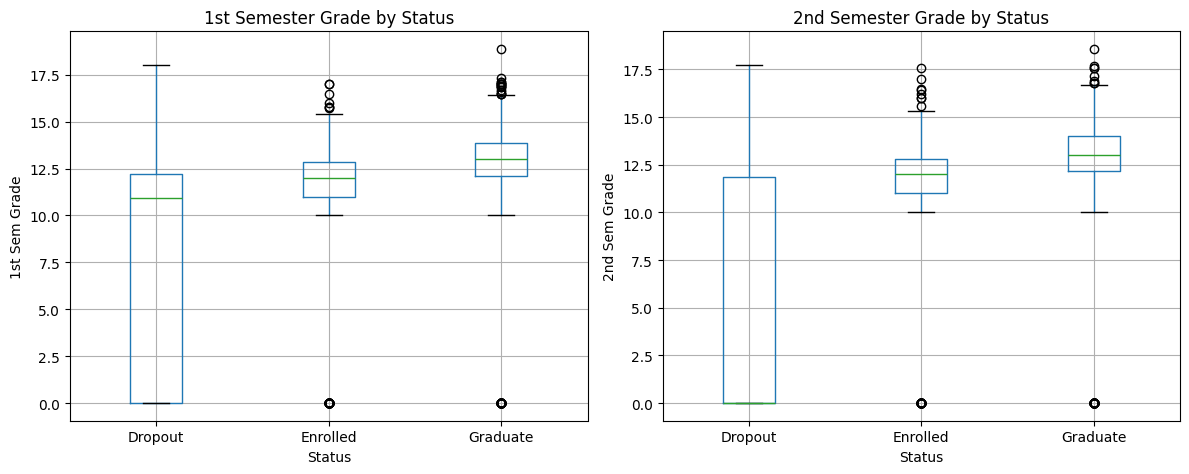

Rata-rata Admission_grade per Status:
      Status  Admission_grade
0   Dropout       124.961365
1  Enrolled       125.534257
2  Graduate       128.794432


In [5]:
# 4. Distribution of target variable 'Status'
status_counts = df['Status'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=status_counts.index, y=status_counts.values)
plt.title('Distribution of Status (Active vs Dropout)')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# 6. Histogram untuk fitur numerik penting
plt.figure()
df.boxplot(column='Age_at_enrollment', by='Status')
plt.xlabel('Status')
plt.ylabel('Age at Enrollment')
plt.title('Distribusi Usia Saat Enroll berdasarkan Status')
plt.suptitle('')  # Hapus default title
plt.tight_layout()
plt.show()
# 7. Boxplot numerik per Status
# for feat in num_features:
#     plt.figure(figsize=(6, 4))
#     sns.boxplot(data=df, x='Status', y=feat)
#     plt.title(f'{feat} by Status')
#     plt.tight_layout()
#     plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Debtor vs Status
sns.countplot(data=df, x='Debtor', hue='Status', ax=axes[0])
axes[0].set_title('Debtor by Status')
axes[0].set_xlabel('Debtor (0 = No, 1 = Yes)')
axes[0].set_ylabel('Count')

# Tuition_fees_up_to_date vs Status
sns.countplot(data=df, x='Tuition_fees_up_to_date', hue='Status', ax=axes[1])
axes[1].set_title('Tuition Fees Up to Date by Status')
axes[1].set_xlabel('Tuition Fees Up to Date (0 = No, 1 = Yes)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Boxplot Admission_grade per Status
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='Status', y='Admission_grade')
plt.title('Admission Grade by Status')
plt.xlabel('Status')
plt.ylabel('Admission Grade')
plt.tight_layout()
plt.show()

# Distribusi (KDE) Admission_grade per Status
plt.figure(figsize=(6, 4))
sns.kdeplot(data=df[df['Status']=='Active']['Admission_grade'], label='Active', fill=True)
sns.kdeplot(data=df[df['Status']=='Dropout']['Admission_grade'], label='Dropout', fill=True)
plt.title('Density Admission Grade by Status')
plt.xlabel('Admission Grade')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# Statistik deskriptif
adm_stats = df.groupby('Status')['Admission_grade'].describe().round(2)
print("Descriptive Statistics Admission_grade per Status:\n", adm_stats)

# 8. Countplot beberapa fitur kategorikal vs Status
cat_features = [
    'Scholarship_holder',
    'Daytime_evening_attendance'
]
for feat in cat_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=feat, hue='Status')
    plt.title(f'{feat} count by Status')
    plt.legend(title='Status', loc='upper right')
    plt.tight_layout()
    plt.show()

statuses = df['Status'].dropna().unique()
for st in statuses:
    plt.figure(figsize=(8, 5))
    subset = df[df['Status'] == st]['Previous_qualification_grade'].dropna()
    plt.hist(subset, bins=20, edgecolor='k')
    plt.title(f'Distribusi Grade untuk Status "{st}"')
    plt.xlabel('Previous Qualification Grade')
    plt.ylabel('Jumlah Samples')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Buat dua boxplot berdampingan: nilai semester 1 dan semester 2 berdasarkan status
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot untuk nilai 1st semester
df.boxplot(column='Curricular_units_1st_sem_grade', by='Status', ax=axs[0])
axs[0].set_title('1st Semester Grade by Status')
axs[0].set_xlabel('Status')
axs[0].set_ylabel('1st Sem Grade')

# Boxplot untuk nilai 2nd semester
df.boxplot(column='Curricular_units_2nd_sem_grade', by='Status', ax=axs[1])
axs[1].set_title('2nd Semester Grade by Status')
axs[1].set_xlabel('Status')
axs[1].set_ylabel('2nd Sem Grade')

# Hapus judul bawaan dan atur layout
plt.suptitle('')
plt.tight_layout()
plt.show()

# 9. Insight kuantitatif sederhana: rata-rata Admission_grade per Status
mean_adm = df.groupby('Status')['Admission_grade'].mean().reset_index()
print('Rata-rata Admission_grade per Status:\n', mean_adm)


## Modeling

Tahap ini melatih model Random Forest, memprediksi data test, lalu menyimpan model dengan joblib supaya bisa dipakai ulang untuk prediksi cepat tanpa pelatihan ulang.

In [6]:
# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Test Model
y_pred = model.predict(X_test)

# Simpan ke Joblib
joblib.dump((model, label_encoders), 'model.pkl')

['model.pkl']

## Evaluation

Tahap ini menampilkan hasil evaluasi model dengan tiga metrik utama:
1. Classification Report
Menyajikan metrik utama seperti precision (ketepatan prediksi positif), recall (kemampuan menangkap semua data positif), f1-score (harmonik rata-rata precision dan recall), serta support (jumlah sampel tiap kelas). Ini membantu memahami performa model secara detail per kelas.

2. Accuracy Score
Mengukur persentase prediksi yang benar dari total data. Mudah dipahami tapi kurang sensitif jika data tidak seimbang antar kelas.

3. Confusion Matrix
Menampilkan matriks yang memperlihatkan jumlah prediksi benar dan salah untuk masing-masing kelas (true positives, false positives, true negatives, false negatives). Berguna untuk analisis kesalahan spesifik model.

In [7]:
# Predict and eval

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       442
           1       0.86      0.82      0.84       284

    accuracy                           0.88       726
   macro avg       0.88      0.87      0.87       726
weighted avg       0.88      0.88      0.88       726


Accuracy Score: 0.8787878787878788

Confusion Matrix:
[[404  38]
 [ 50 234]]


In [8]:
!pip freeze > requirements.txt

In [9]:
import sqlite3

# 1. Baca dataset CSV
df = pd.read_csv('data.csv', sep=';')  # ganti dengan nama file aslimu

# 2. Buat koneksi SQLite
conn = sqlite3.connect('data_mahasiswa.db')  # nama file database

# 3. Simpan ke dalam tabel SQLite (misalnya 'mahasiswa')
df.to_sql('mahasiswa', conn, if_exists='replace', index=False)

# 4. Tutup koneksi
conn.close()

print(f"✅ Berhasil menyimpan {len(df)} baris ke data_mahasiswa.db (tabel: mahasiswa)")

✅ Berhasil menyimpan 4424 baris ke data_mahasiswa.db (tabel: mahasiswa)
